In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import downscale_local_mean
import os
from tqdm import tqdm_notebook
import cv2
from sklearn.model_selection import train_test_split

In [2]:
# Load training files
input_folder = os.getcwd()+"/samples"
files = os.listdir(input_folder+"/carvana_train")
files = [x.split(".")[0] for x in files]
df_mask = pd.DataFrame(files, columns = ['img'])
num_images = len(df_mask)+1

In [ ]:
# Load testing files and save features
"""
df_test = pd.read_csv("carvana_evaluation_images.csv")
input_folder = os.getcwd()+"/samples"
df_test["orig"] = df_test["orig"].apply(lambda x: x.split(".")[0])

num_images = len(df_test)+1
resize = lambda im: downscale_local_mean(im, (5,5) if im.ndim==2 else (5,5,1))

X = np.empty((num_images, 256, 384, 5), dtype=np.float32)
y = np.empty((num_images, 256, 384, 1), dtype=np.float32)

with tqdm_notebook(total=num_images) as bar:
    for i, img_id in enumerate(df_test["orig"]):
        train_img = resize(imread(input_folder+"/carvana_test/"+img_id+".jpg"))
        X[i, ..., :3] = train_img
        del train_img
        mask_img = resize(imread(input_folder+"/carvana_test_masks/"+img_id+"_mask.gif"))
        y[i] = np.expand_dims(mask_img, 2) / 255.
        del mask_img 
        bar.update()

np.save("X_features_test", X)
np.save("y_masks_test", y)
"""

In [ ]:
# Save training file features
"""
num_images = len(df_mask)+1
resize = lambda im: downscale_local_mean(im, (5,5) if im.ndim==2 else (5,5,1))

X = np.empty((num_images, 256, 384, 5), dtype=np.float32)
y = np.empty((num_images, 256, 384, 1), dtype=np.float32)

with tqdm_notebook(total=num_images) as bar:
    for i, img_id in enumerate(df_mask["img"]):
        train_img = resize(imread(input_folder+"/carvana_train/"+img_id+".jpg"))
        X[i, ..., :3] = train_img
        del train_img
        mask_img = resize(imread(input_folder+"/carvana_train_masks/"+img_id+"_mask.gif"))
        y[i] = np.expand_dims(mask_img, 2) / 255.
        del mask_img 
        bar.update()

np.save("X_features", X)
np.save("y_masks", y)
"""

In [ ]:
"""
X = np.load("X_features_test.npy")
mesh_x, mesh_y = np.meshgrid(range(384), range(256))

mesh_x = mesh_x.reshape((1, mesh_x.shape[0], mesh_x.shape[1], 1))
mesh_y = mesh_x.reshape((1, mesh_y.shape[0], mesh_y.shape[1], 1))

mesh_x = np.broadcast_to(mesh_x, (*X.shape[:-1], 1))
mesh_y = np.broadcast_to(mesh_y, (*X.shape[:-1], 1))

X[:,:,:,3:] = np.concatenate([mesh_x, mesh_y], axis=-1)
np.save("X_features_test.npy", X)
"""

In [ ]:
"""
X = np.load("X_features.npy")
mesh_x, mesh_y = np.meshgrid(range(384), range(256))

mesh_x = mesh_x.reshape((1, mesh_x.shape[0], mesh_x.shape[1], 1))
mesh_y = mesh_x.reshape((1, mesh_y.shape[0], mesh_y.shape[1], 1))

mesh_x = np.broadcast_to(mesh_x, (*X.shape[:-1], 1))
mesh_y = np.broadcast_to(mesh_y, (*X.shape[:-1], 1))

X[:,:,:,3:] = np.concatenate([mesh_x, mesh_y], axis=-1)
np.save("X_features.npy", X)
"""

In [3]:
"""
import numpy as np
X = np.load("X_features.npy")
y = np.load("y_masks.npy")
prev = 0
for i, num in enumerate(np.linspace(0, num_images, 5, dtype=np.int)[1:]):
    print(prev, num)
    np.save("X_features_"+str(i), X[prev:num])
    np.save("y_masks_"+str(i), y[prev:num])
    prev = num
"""

0 1259
1259 2519
2519 3779
3779 5039


In [47]:
# Create simple CNN model
from keras.layers import Conv2D
from keras.models import Sequential
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy


model = Sequential()
model.add( Conv2D(64, 3, activation='relu', padding='same', input_shape=(256, 384, 5)))
model.add( Conv2D(64, 3, activation='relu', padding='same') )
model.add( Conv2D(64, 3, activation='relu', padding='same') )
model.add( Conv2D(64, 3, activation='relu', padding='same') )
model.add( Conv2D(64, 3, activation='relu', padding='same') )
model.add( Conv2D(64, 3, activation='relu', padding='same') )
model.add( Conv2D(64, 3, activation='relu', padding='same') )
model.add( Conv2D(64, 3, activation='relu', padding='same') )
model.add( Conv2D(1, 5, activation='sigmoid', padding='same') )

In [48]:
smooth = 1.
# From here: https://github.com/jocicmarko/ultrasound-nerve-segmentation/blob/master/train.py
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    tmp = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return tmp


def bce_dice_loss(y_true, y_pred):
    return 0.5 * binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

model.compile(Adam(lr=1e-3), bce_dice_loss, metrics=['accuracy', dice_coef])

In [49]:
#Train model over partitions of training data
for i in range(4):
    X = np.load("X_features_"+str(i)+".npy")
    y = np.load("y_masks_"+str(i)+".npy")
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    model.fit(X_train, y_train, epochs=15, validation_data=(X_val, y_val), batch_size=5, verbose=2)
    del X, y, X_train, X_val, y_train, y_val

Train on 1007 samples, validate on 252 samples
Epoch 1/15
 - 18s - loss: -3.3774e-01 - accuracy: 0.8569 - dice_coef: 0.5860 - val_loss: -5.8008e-01 - val_accuracy: 0.9034 - val_dice_coef: 0.7332
Epoch 2/15
 - 17s - loss: -6.2254e-01 - accuracy: 0.9145 - dice_coef: 0.7577 - val_loss: -6.4178e-01 - val_accuracy: 0.9196 - val_dice_coef: 0.7661
Epoch 3/15
 - 17s - loss: -5.2254e-01 - accuracy: 0.8943 - dice_coef: 0.7003 - val_loss: -5.8840e-01 - val_accuracy: 0.9035 - val_dice_coef: 0.7547
Epoch 4/15
 - 17s - loss: -6.6296e-01 - accuracy: 0.9220 - dice_coef: 0.7848 - val_loss: -6.8305e-01 - val_accuracy: 0.9290 - val_dice_coef: 0.8165
Epoch 5/15
 - 17s - loss: -7.3847e-01 - accuracy: 0.9391 - dice_coef: 0.8355 - val_loss: -7.3926e-01 - val_accuracy: 0.9408 - val_dice_coef: 0.8503
Epoch 6/15
 - 17s - loss: -7.6090e-01 - accuracy: 0.9446 - dice_coef: 0.8506 - val_loss: -7.6881e-01 - val_accuracy: 0.9473 - val_dice_coef: 0.8650
Epoch 7/15
 - 17s - loss: -7.8918e-01 - accuracy: 0.9508 - dice_c

Epoch 10/15
 - 17s - loss: -8.8336e-01 - accuracy: 0.9748 - dice_coef: 0.9392 - val_loss: -9.2238e-01 - val_accuracy: 0.9800 - val_dice_coef: 0.9555
Epoch 11/15
 - 17s - loss: -8.8938e-01 - accuracy: 0.9756 - dice_coef: 0.9419 - val_loss: -9.2391e-01 - val_accuracy: 0.9802 - val_dice_coef: 0.9536
Epoch 12/15
 - 17s - loss: -9.0134e-01 - accuracy: 0.9762 - dice_coef: 0.9437 - val_loss: -9.1155e-01 - val_accuracy: 0.9780 - val_dice_coef: 0.9456
Epoch 13/15
 - 17s - loss: -8.9355e-01 - accuracy: 0.9751 - dice_coef: 0.9398 - val_loss: -9.0132e-01 - val_accuracy: 0.9757 - val_dice_coef: 0.9387
Epoch 14/15
 - 17s - loss: -9.1362e-01 - accuracy: 0.9778 - dice_coef: 0.9490 - val_loss: -9.3153e-01 - val_accuracy: 0.9818 - val_dice_coef: 0.9600
Epoch 15/15
 - 17s - loss: -8.8862e-01 - accuracy: 0.9758 - dice_coef: 0.9431 - val_loss: -9.2466e-01 - val_accuracy: 0.9803 - val_dice_coef: 0.9543


In [50]:
#pd.DataFrame(history.history)[['dice_coef', 'val_dice_coef']].plot()
model.save_weights("image_segmentation_model_64_filters.h5")


In [52]:
model.load_weights("image_segmentation_model_64_filters.h5")
y_test_masks = np.load("y_masks_test.npy")
X_test_features = np.load("X_features_test.npy")
y_pred = model.predict(X_test_features)
print(np.shape(y_pred))

(51, 256, 384, 1)


In [53]:
def calculate_dice(true_mask, predicted_mask):
    # Predicted mask must be reshaped from (1280,1918,1) to (1280,1918)
    row, height = np.shape(true_mask)
    predicted_mask = np.reshape(predicted_mask, (row,height))
    
    print("True mask:", np.shape(true_mask))
    print("Predicted mask:", np.shape(predicted_mask))
    
    # True mask pixels are either 0 (black) or 255 (white). Convert to booleans
    true_mask = np.array(true_mask, dtype=int)
    true_mask = np.greater(true_mask, 0)
    print("True mask counts:", np.unique(true_mask, return_counts=True))
    
    # Pred mask pixels are either 0 (black) or 255 (white). Convert to booleans
    predicted_mask = np.array(predicted_mask, dtype=int)
    predicted_mask = np.greater(predicted_mask, 0)
    print("Predicted mask counts:", np.unique(predicted_mask, return_counts=True))
    
    # Count the number of pixels in each mask and the intersection of pixels between masks
    pred_pixels = np.count_nonzero(predicted_mask)
    true_pixels = np.count_nonzero(true_mask)
    intersect = np.sum(np.multiply(true_mask, predicted_mask))
    
    
    # Calculate the mean Dice coefficient
    return (2*intersect)/(pred_pixels + true_pixels)

3810c5e1cdeb_01.jpg
True mask: (256, 384)
Predicted mask: (256, 384)
True mask counts: (array([False,  True]), array([83613, 14691]))
Predicted mask counts: (array([False,  True]), array([83760, 14544]))
Score: 0.9284761416110826


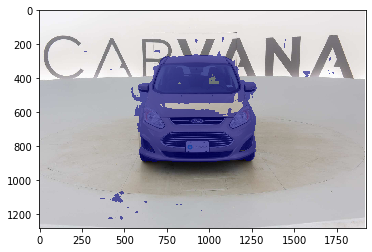

2af7c265531e_10.jpg
True mask: (256, 384)
Predicted mask: (256, 384)
True mask counts: (array([False,  True]), array([81350, 16954]))
Predicted mask counts: (array([False,  True]), array([80760, 17544]))
Score: 0.9764044292422749


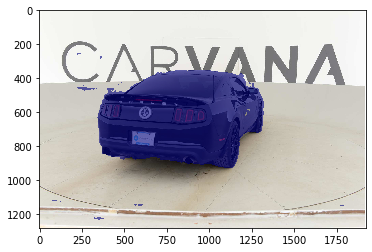

78bfb9c780db_08.jpg
True mask: (256, 384)
Predicted mask: (256, 384)
True mask counts: (array([False,  True]), array([77121, 21183]))
Predicted mask counts: (array([False,  True]), array([75841, 22463]))
Score: 0.9445539110113184


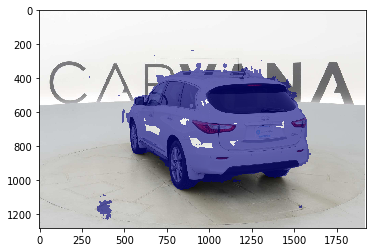

dd47eb7ac4ee_03.jpg
True mask: (256, 384)
Predicted mask: (256, 384)
True mask counts: (array([False,  True]), array([79945, 18359]))
Predicted mask counts: (array([False,  True]), array([78562, 19742]))
Score: 0.9598173276291961


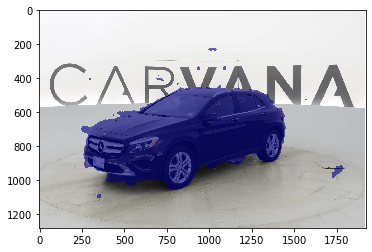

3bca821c8c41_03.jpg
True mask: (256, 384)
Predicted mask: (256, 384)
True mask counts: (array([False,  True]), array([76840, 21464]))
Predicted mask counts: (array([False,  True]), array([77864, 20440]))
Score: 0.9315578465063001


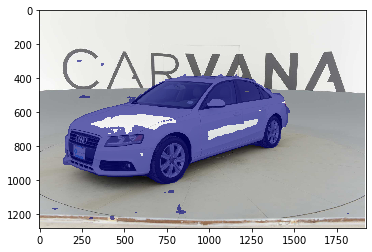

cf89c3220bc4_04.jpg
True mask: (256, 384)
Predicted mask: (256, 384)
True mask counts: (array([False,  True]), array([74930, 23374]))
Predicted mask counts: (array([False,  True]), array([72850, 25454]))
Score: 0.9569918898992381


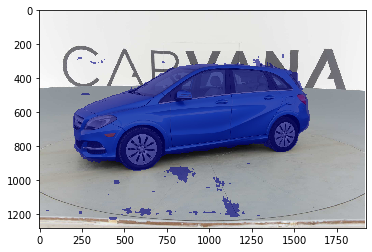

528eb34a4c29_11.jpg
True mask: (256, 384)
Predicted mask: (256, 384)
True mask counts: (array([False,  True]), array([72772, 25532]))
Predicted mask counts: (array([False,  True]), array([72156, 26148]))
Score: 0.975735294117647


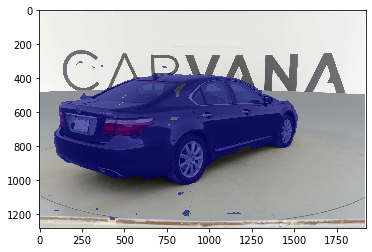

d8e1c401ac3c_01.jpg
True mask: (256, 384)
Predicted mask: (256, 384)
True mask counts: (array([False,  True]), array([80084, 18220]))
Predicted mask counts: (array([False,  True]), array([79090, 19214]))
Score: 0.9265907998076615


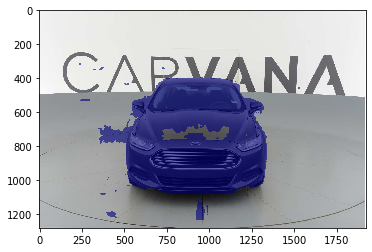

4f1f065d78ac_16.jpg
True mask: (256, 384)
Predicted mask: (256, 384)
True mask counts: (array([False,  True]), array([81764, 16540]))
Predicted mask counts: (array([False,  True]), array([82071, 16233]))
Score: 0.9367467122326305


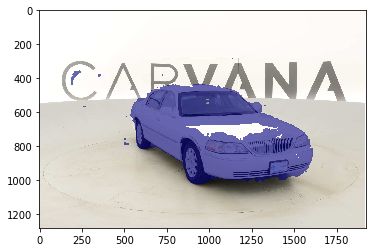

8b88fb784951_01.jpg
True mask: (256, 384)
Predicted mask: (256, 384)
True mask counts: (array([False,  True]), array([79412, 18892]))
Predicted mask counts: (array([False,  True]), array([79598, 18706]))
Score: 0.9313793286876961


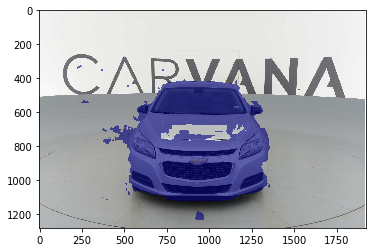

344ece157efc_05.jpg
True mask: (256, 384)
Predicted mask: (256, 384)
True mask counts: (array([False,  True]), array([69844, 28460]))
Predicted mask counts: (array([False,  True]), array([67832, 30472]))
Score: 0.9531324238104935


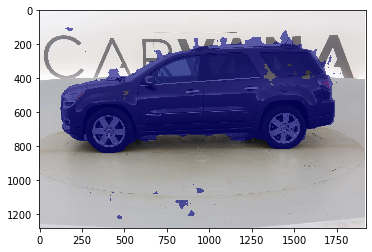

b1a27da4f01c_07.jpg
True mask: (256, 384)
Predicted mask: (256, 384)
True mask counts: (array([False,  True]), array([76577, 21727]))
Predicted mask counts: (array([False,  True]), array([76385, 21919]))
Score: 0.9551848966686524


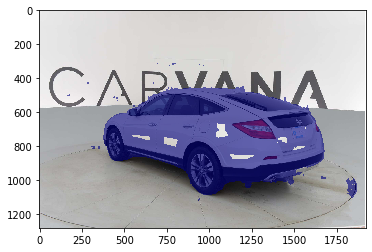

61060ada97c9_02.jpg
True mask: (256, 384)
Predicted mask: (256, 384)
True mask counts: (array([False,  True]), array([66950, 31354]))
Predicted mask counts: (array([False,  True]), array([65715, 32589]))
Score: 0.9652033842641102


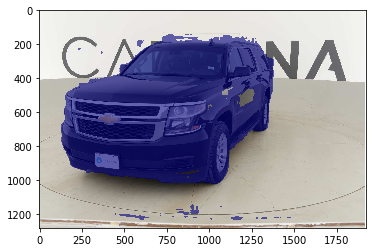

f3eee6348205_01.jpg
True mask: (256, 384)
Predicted mask: (256, 384)
True mask counts: (array([False,  True]), array([79149, 19155]))
Predicted mask counts: (array([False,  True]), array([75833, 22471]))
Score: 0.9196175467256041


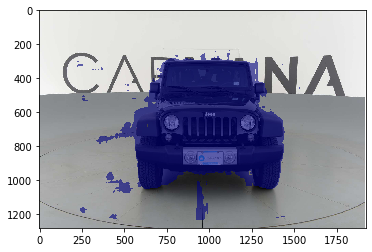

85bc655a7523_10.jpg
True mask: (256, 384)
Predicted mask: (256, 384)
True mask counts: (array([False,  True]), array([79349, 18955]))
Predicted mask counts: (array([False,  True]), array([78596, 19708]))
Score: 0.9499004215917026


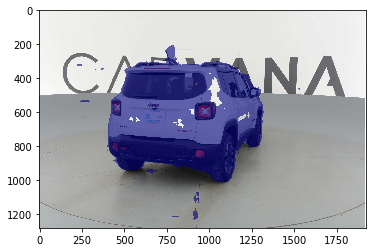

a4551c5409e3_03.jpg
True mask: (256, 384)
Predicted mask: (256, 384)
True mask counts: (array([False,  True]), array([79035, 19269]))
Predicted mask counts: (array([False,  True]), array([79704, 18600]))
Score: 0.941033563072698


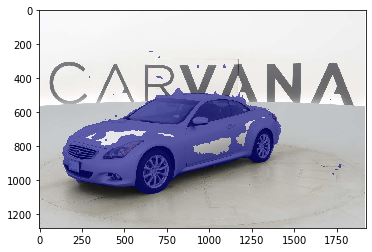

a7c1ef8d9cc9_01.jpg
True mask: (256, 384)
Predicted mask: (256, 384)
True mask counts: (array([False,  True]), array([81881, 16423]))
Predicted mask counts: (array([False,  True]), array([81840, 16464]))
Score: 0.8810776294584486


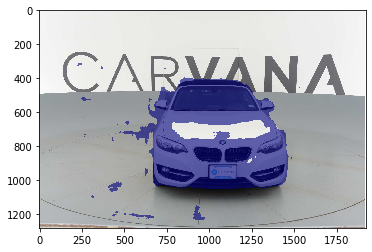

a078586ccdee_10.jpg
True mask: (256, 384)
Predicted mask: (256, 384)
True mask counts: (array([False,  True]), array([80508, 17796]))
Predicted mask counts: (array([False,  True]), array([79612, 18692]))
Score: 0.9721004165753124


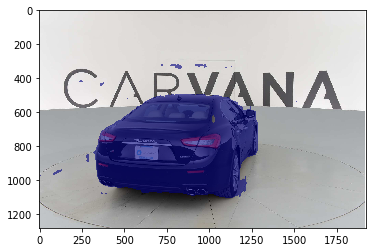

8d5423cb763c_09.jpg
True mask: (256, 384)
Predicted mask: (256, 384)
True mask counts: (array([False,  True]), array([83452, 14852]))
Predicted mask counts: (array([False,  True]), array([83505, 14799]))
Score: 0.9393949613841017


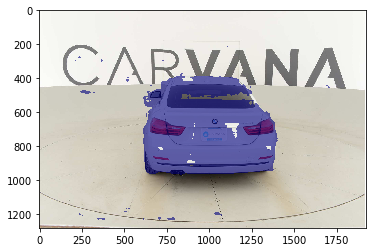

61060ada97c9_07.jpg
True mask: (256, 384)
Predicted mask: (256, 384)
True mask counts: (array([False,  True]), array([60940, 37364]))
Predicted mask counts: (array([False,  True]), array([60563, 37741]))
Score: 0.9331469276346448


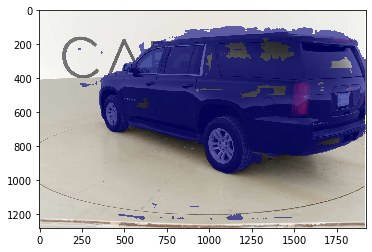

ed13cbcdd5d8_06.jpg
True mask: (256, 384)
Predicted mask: (256, 384)
True mask counts: (array([False,  True]), array([71657, 26647]))
Predicted mask counts: (array([False,  True]), array([73164, 25140]))
Score: 0.890107555950335


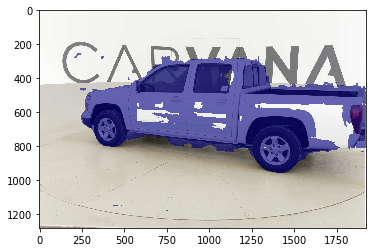

2990f858e939_11.jpg
True mask: (256, 384)
Predicted mask: (256, 384)
True mask counts: (array([False,  True]), array([76059, 22245]))
Predicted mask counts: (array([False,  True]), array([75014, 23290]))
Score: 0.9761282529922038


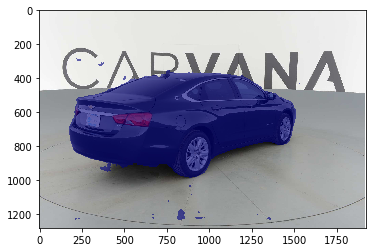

11acc40dc0ea_14.jpg
True mask: (256, 384)
Predicted mask: (256, 384)
True mask counts: (array([False,  True]), array([72914, 25390]))
Predicted mask counts: (array([False,  True]), array([71723, 26581]))
Score: 0.9753516384137307


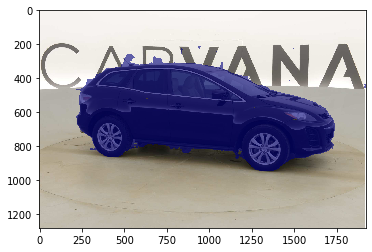

6f6dced498c4_11.jpg
True mask: (256, 384)
Predicted mask: (256, 384)
True mask counts: (array([False,  True]), array([71118, 27186]))
Predicted mask counts: (array([False,  True]), array([69810, 28494]))
Score: 0.9757183908045977


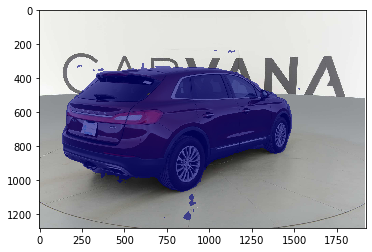

4a4364d7fc6d_13.jpg
True mask: (256, 384)
Predicted mask: (256, 384)
True mask counts: (array([False,  True]), array([63008, 35296]))
Predicted mask counts: (array([False,  True]), array([61392, 36912]))
Score: 0.9282074008420119


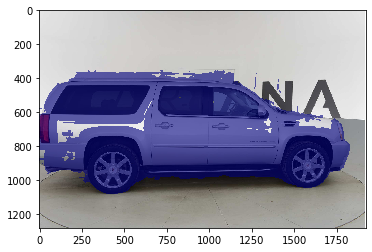

28d9a149cb02_11.jpg
True mask: (256, 384)
Predicted mask: (256, 384)
True mask counts: (array([False,  True]), array([84261, 14043]))
Predicted mask counts: (array([False,  True]), array([82304, 16000]))
Score: 0.9338614652331658


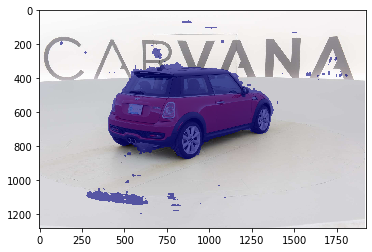

f3eee6348205_12.jpg
True mask: (256, 384)
Predicted mask: (256, 384)
True mask counts: (array([False,  True]), array([71271, 27033]))
Predicted mask counts: (array([False,  True]), array([68318, 29986]))
Score: 0.9473333450253424


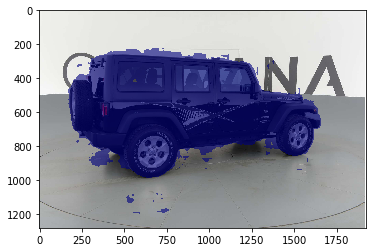

0ee135a3cccc_16.jpg
True mask: (256, 384)
Predicted mask: (256, 384)
True mask counts: (array([False,  True]), array([78571, 19733]))
Predicted mask counts: (array([False,  True]), array([77460, 20844]))
Score: 0.9169233802400375


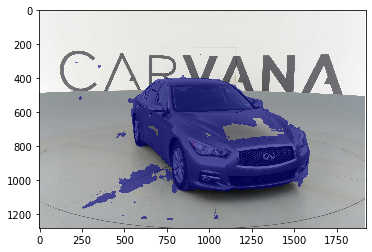

791c1a9775be_06.jpg
True mask: (256, 384)
Predicted mask: (256, 384)
True mask counts: (array([False,  True]), array([78505, 19799]))
Predicted mask counts: (array([False,  True]), array([77014, 21290]))
Score: 0.9617659227530483


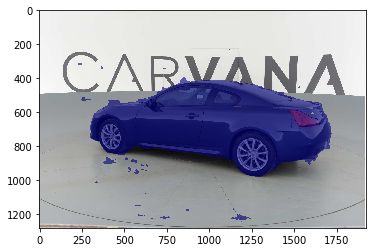

4fc2470c0f7b_05.jpg
True mask: (256, 384)
Predicted mask: (256, 384)
True mask counts: (array([False,  True]), array([71569, 26735]))
Predicted mask counts: (array([False,  True]), array([68766, 29538]))
Score: 0.9483055817176976


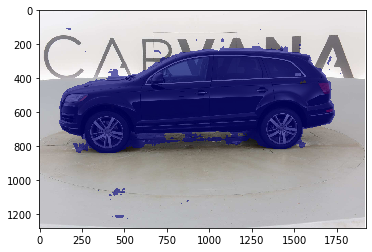

8b4b87ad7be6_02.jpg
True mask: (256, 384)
Predicted mask: (256, 384)
True mask counts: (array([False,  True]), array([81283, 17021]))
Predicted mask counts: (array([False,  True]), array([80603, 17701]))
Score: 0.9613501526409769


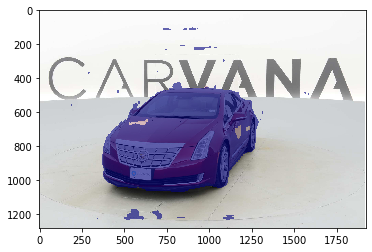

a3e2e104d58a_10.jpg
True mask: (256, 384)
Predicted mask: (256, 384)
True mask counts: (array([False,  True]), array([81064, 17240]))
Predicted mask counts: (array([False,  True]), array([79663, 18641]))
Score: 0.958223014966138


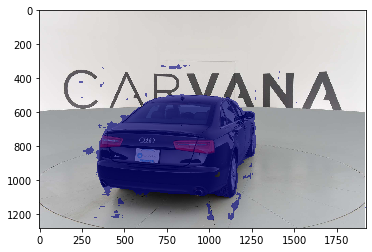

a46baa0b3ac0_08.jpg
True mask: (256, 384)
Predicted mask: (256, 384)
True mask counts: (array([False,  True]), array([75284, 23020]))
Predicted mask counts: (array([False,  True]), array([73556, 24748]))
Score: 0.9570423714620666


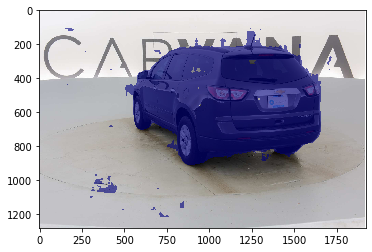

bb2f95262773_09.jpg
True mask: (256, 384)
Predicted mask: (256, 384)
True mask counts: (array([False,  True]), array([85192, 13112]))
Predicted mask counts: (array([False,  True]), array([84289, 14015]))
Score: 0.9651638588859808


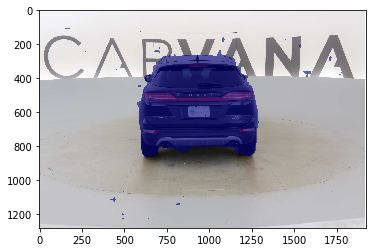

65051cfe0789_05.jpg
True mask: (256, 384)
Predicted mask: (256, 384)
True mask counts: (array([False,  True]), array([75140, 23164]))
Predicted mask counts: (array([False,  True]), array([73350, 24954]))
Score: 0.9626335259154578


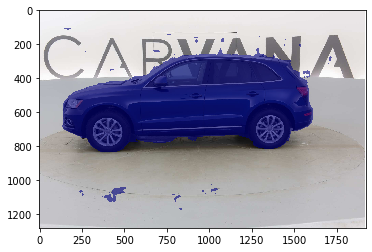

2a4a8964ebf3_15.jpg
True mask: (256, 384)
Predicted mask: (256, 384)
True mask counts: (array([False,  True]), array([75732, 22572]))
Predicted mask counts: (array([False,  True]), array([74585, 23719]))
Score: 0.9733641528590871


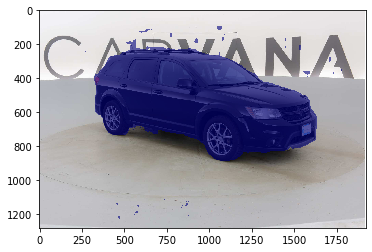

31186febd775_07.jpg
True mask: (256, 384)
Predicted mask: (256, 384)
True mask counts: (array([False,  True]), array([79245, 19059]))
Predicted mask counts: (array([False,  True]), array([77986, 20318]))
Score: 0.967569901211367


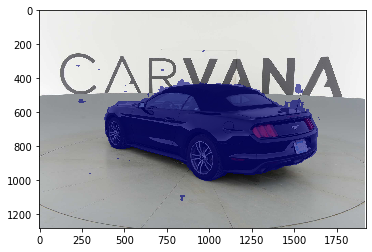

eefc0d8c94f0_14.jpg
True mask: (256, 384)
Predicted mask: (256, 384)
True mask counts: (array([False,  True]), array([74833, 23471]))
Predicted mask counts: (array([False,  True]), array([68339, 29965]))
Score: 0.8431394565461486


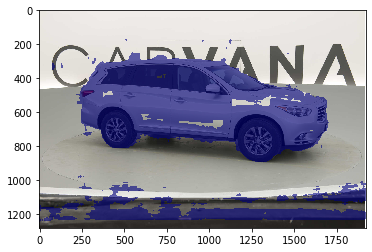

cf89c3220bc4_05.jpg
True mask: (256, 384)
Predicted mask: (256, 384)
True mask counts: (array([False,  True]), array([74838, 23466]))
Predicted mask counts: (array([False,  True]), array([71223, 27081]))
Score: 0.9282054325677093


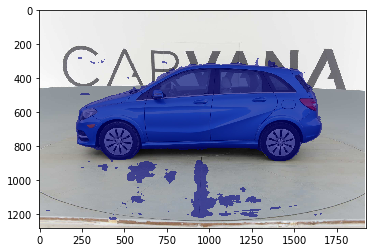

3c6acfceb552_10.jpg
True mask: (256, 384)
Predicted mask: (256, 384)
True mask counts: (array([False,  True]), array([85387, 12917]))
Predicted mask counts: (array([False,  True]), array([84451, 13853]))
Score: 0.949346283152783


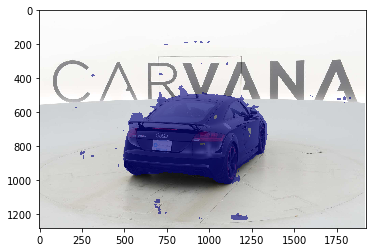

b58cc561e560_14.jpg
True mask: (256, 384)
Predicted mask: (256, 384)
True mask counts: (array([False,  True]), array([74013, 24291]))
Predicted mask counts: (array([False,  True]), array([75109, 23195]))
Score: 0.934843954007497


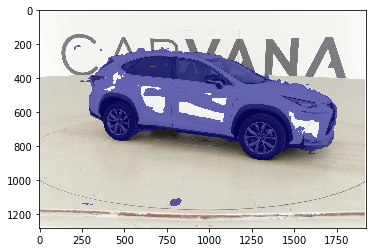

a7c1ef8d9cc9_07.jpg
True mask: (256, 384)
Predicted mask: (256, 384)
True mask counts: (array([False,  True]), array([79935, 18369]))
Predicted mask counts: (array([False,  True]), array([79381, 18923]))
Score: 0.9437949157996353


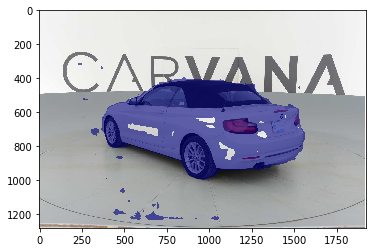

99639c826ea5_12.jpg
True mask: (256, 384)
Predicted mask: (256, 384)
True mask counts: (array([False,  True]), array([66117, 32187]))
Predicted mask counts: (array([False,  True]), array([63982, 34322]))
Score: 0.9353019892044686


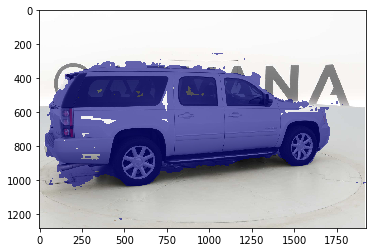

ba7e7421003b_11.jpg
True mask: (256, 384)
Predicted mask: (256, 384)
True mask counts: (array([False,  True]), array([77827, 20477]))
Predicted mask counts: (array([False,  True]), array([76810, 21494]))
Score: 0.975483071644707


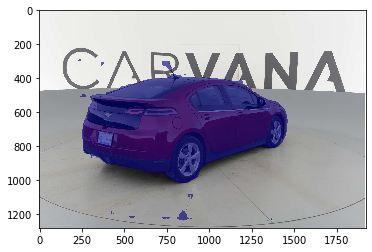

f00905abd3d7_02.jpg
True mask: (256, 384)
Predicted mask: (256, 384)
True mask counts: (array([False,  True]), array([78066, 20238]))
Predicted mask counts: (array([False,  True]), array([78388, 19916]))
Score: 0.9462071026547791


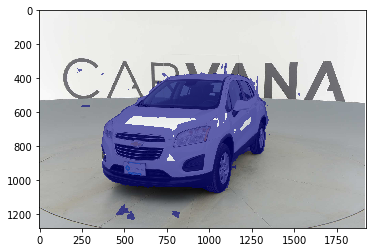

7251c8797749_06.jpg
True mask: (256, 384)
Predicted mask: (256, 384)
True mask counts: (array([False,  True]), array([77499, 20805]))
Predicted mask counts: (array([False,  True]), array([76208, 22096]))
Score: 0.9653388032912986


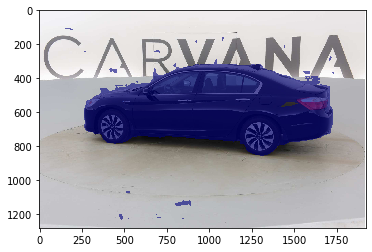

6c0cd487abcd_01.jpg
True mask: (256, 384)
Predicted mask: (256, 384)
True mask counts: (array([False,  True]), array([81099, 17205]))
Predicted mask counts: (array([False,  True]), array([81721, 16583]))
Score: 0.9351248964129276


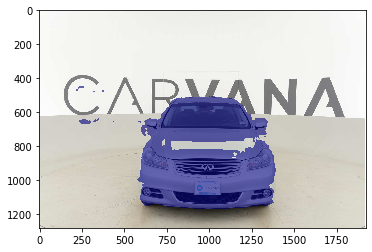

1ba84b81628e_04.jpg
True mask: (256, 384)
Predicted mask: (256, 384)
True mask counts: (array([False,  True]), array([74636, 23668]))
Predicted mask counts: (array([False,  True]), array([73166, 25138]))
Score: 0.9659877883866738


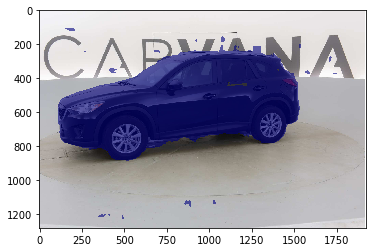

eb91b1c659a0_15.jpg
True mask: (256, 384)
Predicted mask: (256, 384)
True mask counts: (array([False,  True]), array([69996, 28308]))
Predicted mask counts: (array([False,  True]), array([65878, 32426]))
Score: 0.9248526360852241


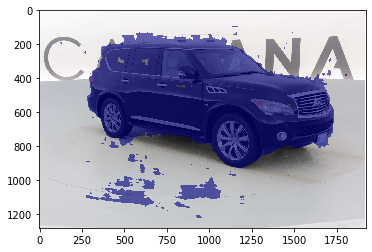

Average dice score: 0.9454024917060798


In [55]:
import skimage.io
import skimage
from statistics import mean

dice_coefs = []

for image_num in range(49):
    true = np.squeeze(y_test_masks[image_num], axis = 2)
    
    df_test = pd.read_csv("carvana_evaluation_images.csv")
    input_folder = os.getcwd()+"/samples/carvana_test/"
    image = df_test["orig"][image_num]
    print(image)
    mask = np.squeeze(y_pred[image_num], axis = 2)
    masked = np.ma.masked_where(mask > .1, mask)
    
    score = calculate_dice(true, masked.mask)
    print("Score:", score)
    dice_coefs.append(score)
   
    # Transform for the full size image
    mask = skimage.transform.pyramid_expand(mask, 5)
    #print(mask)
    masked = np.ma.masked_where(mask < .1, mask)
    #print(masked)
    masked = (masked > 0).astype(int)
    img = skimage.io.imread(input_folder+image)
    plt.figure()
    plt.imshow(img, alpha = 1)
    plt.imshow(masked, cmap = 'jet', alpha = .6)
    plt.show()

print("Average dice score:", mean(dice_coefs))